# Arquitetura de Redes Neurais

http://vision.stanford.edu/teaching/cs231n-demos/linear-classify/

<img src="images/linear_class_loss.png" width="500">

O demo de classificacao linear do curso CS231n ilustra como um modelo puramente linear aprende a separar classes ao calcular escores f(x)=Wx+b e ajustar os pesos para minimizar diferentes funcoes de perda. A superficie mostrada acima evidencia como criterios como hinge loss criam vales que empurram a fronteira decisoria na direcao correta, mas tambem revela que solucoes lineares sao limitadas quando os dados nao sao separaveis por um hiperplano.

Neste notebook damos continuidade a essa ideia construindo arquiteturas em PyTorch. Comecamos com dados em formato de duas luas, que desafiam um classificador linear simples, e experimentamos tanto a versao sequencial quanto a implementacao manual de uma rede com camada escondida e ativacao nao linear. A meta e mostrar como a combinacao de camadas lineares com funcoes de ativacao expande o espaco de hipoteses, permitindo que o modelo capture padroes complexos onde a classificacao linear tradicional falha.


https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html

Para complementar a discussao, explorei o demo interativo do ConvNetJS usando o *circle data*, onde as classes formam aneis concentricos. Configurei a rede com uma camada de entrada 2D, uma camada totalmente conectada de 6 neuronios ativados por ReLU e uma camada final softmax.

```javascript
layer_defs = [];
layer_defs.push({type:'input', out_sx:1, out_sy:1, out_depth:2});
layer_defs.push({type:'fc', num_neurons:6, activation: 'relu'});
layer_defs.push({type:'softmax', num_classes:2});

net = new convnetjs.Net();
net.makeLayers(layer_defs);

trainer = new convnetjs.SGDTrainer(net, {learning_rate:0.01, momentum:0.1, batch_size:10, l2_decay:0.001});
```

Mesmo com uma arquitetura pequena, o modelo consegue esculpir uma fronteira de decisao nao linear e separar os dados circulares apos alguns ciclos de treino. Essa experiencia ajuda a visualizar o papel das camadas escondidas com ReLU em expandir a capacidade de representacao de redes neurais, exatamente o que vamos reproduzir a seguir com PyTorch.

<img src="images/circle_data.png" width="500">


# Definindo uma Arquitetura no PyTorch

**Carregando dados**

Exemplo de dados não-linearmente separáveis (distribuição em lua): <br>
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

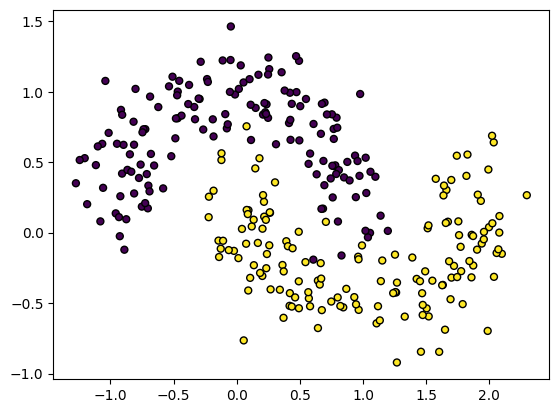

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Gera dados sintéticos em formato de duas meias-luas
X1, Y1 = make_moons(n_samples=300, noise=0.2)
# Visualiza as amostras coloridas por classe
plt.scatter(X1[:, 0], X1[:, 1], marker='o', 
 c=Y1, s=25, edgecolor='k');


## nn.Sequential

O módulo ```nn.Sequential``` é um container onde se pode colocar múltiplos módulos. Ao realizar um ```forward``` em um objeto ```Sequential``` ele aplicará sequencialmente os módulos nele contidas para gerar uma saída.

Segue abaixo um exemplo desse módulo contendo 2 camadas ```Linear``` intercaladas por uma função de ativação ```ReLU```.

In [2]:
import torch
# neural networks
from torch import nn
# Mantém os cálculos na CPU
device = torch.device('cpu')

# Tamanho do vetor de entrada
input_size = 2 
# Quantidade de neurônios na camada escondida 
hidden_size = 8
# Uma única saída escalar
output_size = 1

net = nn.Sequential(nn.Linear(in_features=input_size, out_features=hidden_size), # hidden (escondida)
                    nn.ReLU(),   # ativação não linear
                    nn.Linear(in_features=hidden_size, out_features=output_size)) # output (saída)
print(net)  # Exibe a arquitetura encadeada


Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)


O módulo ```summary``` da biblioteca **```torchsummary```** nos permite visualizar mais informações sobre a nossa rede, como quantidade de parâmetros e o tamanho que cada elemento ocupa na memória.

Para mais informações, acesse: https://github.com/sksq96/pytorch-summary

In [3]:
from torchsummary import summary
# Resume camadas e parâmetros do modelo
summary(net.to(device), input_size=(1, input_size), device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 8]              24
              ReLU-2                 [-1, 1, 8]               0
            Linear-3                 [-1, 1, 1]               9
Total params: 33
Trainable params: 33
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Forward

In [4]:
# Inspeciona dimensões originais do dataset
print(X1.shape)
  # Converte os dados para tensor de ponto flutuante
tensor = torch.from_numpy(X1).float()
# Realiza a propagação para obter as saídas do modelo
pred   = net(tensor)
# Verifica o tamanho do resultado gerado
print(pred.size())


(300, 2)
torch.Size([300, 1])


## Classe nn.Module

A forma mais organizada de definir modelos em PyTorch é implementando uma classe nos moldes da classe ```nn.Module```. Para redes pequenas, como as que estamos aprendendo até o momento, sua importância pode não se destacar, mas modelos maiores e com funcionalidades mais complexas, são mais fáceis de implementar e realizar manutenções dessa forma.

Funções obrigatórias do ```nn.Module```.
* ```__init()__```: definição de hiperparâmetros e instância do modelo 
* ```forward()```: Fluxo da entrada para produzir uma saída

In [5]:
class MinhaRede(nn.Module):  
  '''
  Implementa a mesma arquitetura manualmente
  '''
  def __init__(self, input_size, hidden_size, output_size):
    super(MinhaRede, self).__init__()
    
    # Definir a arquitetura
    self.hidden = nn.Linear(input_size, hidden_size)
    self.relu   = nn.ReLU()
    self.output = nn.Linear(hidden_size, output_size)
    
  def forward(self, X):
    
    # Gerar uma saída a partir do X
    hidden = self.relu(self.hidden(X))
    output = self.output(hidden)
    
    return output


Instanciando a rede

In [11]:
# Entrada com duas características
input_size = 2
# Mesmos neurônios definidos anteriormente
hidden_size = 8
# Saída binária representada por um escalar
output_size = 1

# O método __init__()
net = MinhaRede(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Mostra a estrutura customizada
print(net)


MinhaRede(
  (hidden): Linear(in_features=2, out_features=8, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
)


### Forward

In [12]:
# Confirma dimensões do conjunto antes da inferência
print(X1.shape)  
# Reaproveita os dados como tensor
tensor = torch.from_numpy(X1).float()
# Executa o forward usando a implementação manual
pred   = net(tensor)
# Checa o formato da saída
print(pred.size())


(300, 2)
torch.Size([300, 1])


## Subindo informações na GPU

Para conseguir executar modelos maiores em tempo hábil, é preciso carregar as informação na GPU para que o processamento seja realizado por ela. Dentre as informações que conhecemos até o momento, duas delas precisam ser carregadas ba GPU:
* Entrada
* Rede

A célula a seguir contém a implementação sugerida para realizar esse processo. <br>
Se certifique que o notebook está na configuração desejada (CPU/GPU). Para isso, basta acessar ```Edit -> Notebook Settings``` e definir o hardware desejado.

In [8]:
# if torch.cuda.is_available():
#   device = torch.device('cuda')
# else:
#   device = torch.device('cpu')

# Força o uso da CPU independentemente da disponibilidade de GPU
device = torch.device('cpu')

# Confirma o device selecionado
print(device)


cpu


In [9]:
# Dimensão de cada amostra
input_size = 2
# Camada escondida com oito unidades
hidden_size = 8
# Saída escalar
output_size = 1

# O método __init__()
net = MinhaRede(input_size,hidden_size, output_size)
# Move os pesos para o device escolhido
net = net.to(device)
# Exibe a arquitetura no contexto atualizado
print(net)


MinhaRede(
  (hidden): Linear(in_features=2, out_features=8, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
)


In [10]:
# Exibe novamente as dimensões das entradas
print(X1.shape)
# Converte o numpy array para tensor
tensor = torch.from_numpy(X1).float()
# Garante que os dados estão no mesmo device da rede
tensor = tensor.to(device)
# Executa a inferência
pred   = net(tensor)
# Informa o tamanho da saída gerada
print(pred.size())


(300, 2)
torch.Size([300, 1])
